In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install sklearn

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post7-py3-none-any.whl size=2951 sha256=b644da77af86966725b3bf83c7f8e0cceb16732a90fc80bdf2da7a54b7cb708c
  Stored in directory: /root/.cache/pip/wheels/c8/9c/85/72901eb50bc4bc6e3b2629378d172384ea3dfd19759c77fd2c
Successfully built sklearn


In [ ]:
# excel 읽어서 label list 만들기

In [33]:
import os
import numpy as np

PATH = "/content/drive/MyDrive/output/"

files = os.listdir(PATH)

# max_frames = 207 # 1-1000개만

x_data = []
y_data = []
# y 데이터에 해당하는 label들도 뽑기
for file in files:
    file_path = PATH + file
    data = np.load(file_path)

    x = data[:, :, :-1]
    x = x.astype(float)

    y = data[-1, -1, -1]

    x_data.append(x)
    y_data.append(y)

y_data = np.array(y_data)

print(len(x_data))
print(y_data.shape)

592
(592,)


In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# print(x[0]) # 값이 왜 또 튀지? 왜!? 안 튀네.

x_data = pad_sequences(x_data)
x_data = tf.reshape(x_data, (x_data.shape[0], 102, -1))
x_data = x_data.numpy()
print(x_data.shape)

(592, 102, 156)


In [23]:
y_ = y_data

In [24]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 여기서 섞이는 것 같은데.. 안 섞이네?
le = LabelEncoder()
le.fit(y_) # 중복 제거, 정렬
labels = le.classes_ # 라벨들만 따로 저장
y_data = le.transform(y_) # y_data를 숫자들로 변환

y_data = to_categorical(y_data) # one-hot encoding

print(y_data.shape)

(592, 419)


In [28]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(532, 102, 156) (532, 419)
(60, 102, 156) (60, 419)


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

model = Sequential([
    Masking(mask_value=0., input_shape=x_train.shape[1:3]),
    LSTM(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 102, 156)          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                56576     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 419)               13827     
                                                                 
Total params: 72,483
Trainable params: 72,483
Non-trainable params: 0
_________________________________________________________________


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks=[
        ModelCheckpoint('/content/drive/MyDrive/models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 19.3011 - acc: 0.0094
Epoch 1: val_acc improved from -inf to 0.00000, saving model to /content/drive/MyDrive/models/model.h5
17/17 [==============================] - 3s 176ms/step - loss: 19.3011 - acc: 0.0094 - val_loss: 2183.9973 - val_acc: 0.0000e+00 - lr: 2.5000e-04
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 17.6361 - acc: 0.0094
Epoch 2: val_acc did not improve from 0.00000
17/17 [==============================] - 3s 146ms/step - loss: 17.6361 - acc: 0.0094 - val_loss: 2193.7144 - val_acc: 0.0000e+00 - lr: 2.5000e-04
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 15.7336 - acc: 0.0169
Epoch 3: val_acc did not improve from 0.00000
17/17 [==============================] - 2s 97ms/step - loss: 15.7336 - acc: 0.0169 - val_loss: 2183.6355 - val_acc: 0.0000e+00 - lr: 2.5000e-04
Epoch 4/100
17/17 [==============================] - ETA: 0s - loss: 12.3033 - acc: 0.0169
Epoc

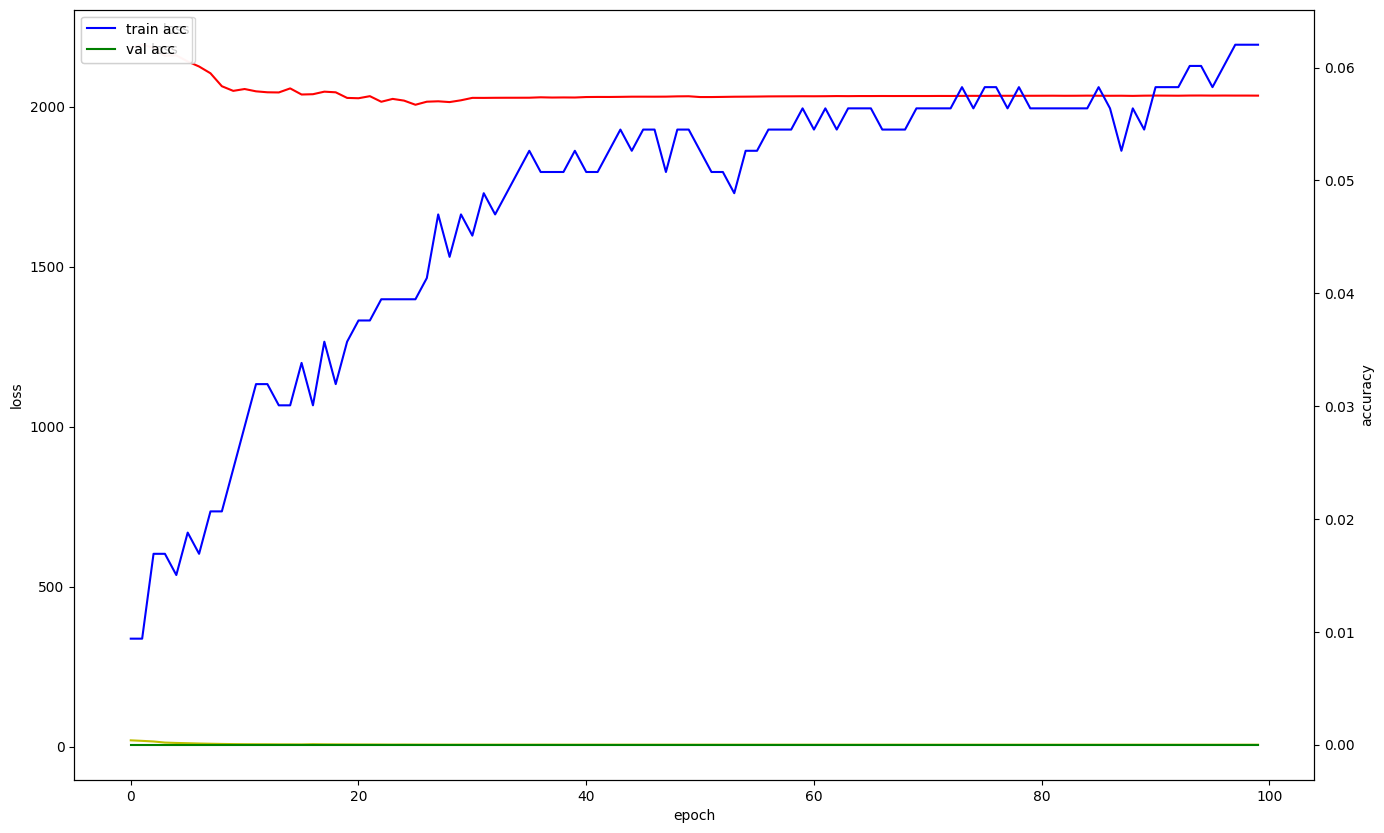

In [41]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [42]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

# model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

2/2 [==============================] - 0s 26ms/step


array([[[58.,  0.],
        [ 2.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  1.],
        [ 0.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[12., 48.],
        [ 0.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  0.],
        [ 1.,  0.]],

       [[59.,  1.],
        [ 0., 